In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import rawpy
import io


In [2]:
RAW_DIR = "images/raw"
COMPRESSED_DIR = "images/compressed"
COMPRESSED_COLOR_DIR = "images/compressed_color"
COMPARISON_DIR = "images/comparison"
JPEG_DIR = "images/jpeg_compressed"

# Create comparison directory if it doesn't exist
os.makedirs(COMPARISON_DIR, exist_ok=True)
# Create JPEG compressed directory if it doesn't exist
os.makedirs(JPEG_DIR, exist_ok=True)

RAW_EXTS = {".arw", ".cr2", ".nef", ".dng", ".raf", ".rw2"}
IMAGE_EXTS = RAW_EXTS | {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp", ".gif", ".webp"}


In [3]:
def load_image(image_path, greyscale=False):
    img = None

    try:
        img = Image.open(image_path)
    except (Image.UnidentifiedImageError, OSError):
        with rawpy.imread(image_path) as raw:
            rgb = raw.postprocess(
                no_auto_bright=True,
                output_bps=8
            )
            img = Image.fromarray(rgb)

    if img is None:
        raise ValueError(f"Could not load image from {image_path}")

    if greyscale:
        img = img.convert('L')
    else:
        img = img.convert('RGB')

    return img


In [4]:
def get_file_size_kb(file_path):
    return os.path.getsize(file_path) / 1024


In [5]:
def compress_with_jpeg(image_path, output_path, quality=85):
    """
    Compress an image using standard JPEG compression with the specified quality.

    Args:
        image_path (str): Path to the input image
        output_path (str): Path to save the compressed image
        quality (int): JPEG quality (1-100, higher is better quality but larger file)
    """
    try:
        # Load the image
        img = load_image(image_path)

        # Save with JPEG compression
        img.save(output_path, format='JPEG', quality=quality)

        print(f"JPEG compressed image saved to: {output_path}")
    except Exception as e:
        print(f"Error compressing image with JPEG: {e}")


In [6]:
def compare_images(original_path, grayscale_path, color_path, jpeg_path=None):
    original_size = get_file_size_kb(original_path)
    grayscale_size = get_file_size_kb(grayscale_path)
    color_size = get_file_size_kb(color_path)

    grayscale_ratio = grayscale_size / original_size * 100
    color_ratio = color_size / original_size * 100

    jpeg_size = None
    jpeg_ratio = None
    if jpeg_path and os.path.exists(jpeg_path):
        jpeg_size = get_file_size_kb(jpeg_path)
        jpeg_ratio = jpeg_size / original_size * 100

    try:
        original_img = load_image(original_path)
        grayscale_img = load_image(grayscale_path)
        color_img = load_image(color_path)
        jpeg_img = load_image(jpeg_path) if jpeg_path and os.path.exists(jpeg_path) else None
    except Exception as e:
        print(f"Error loading images: {e}")
        return

    # Determine number of subplots based on whether JPEG image is available
    num_plots = 4 if jpeg_img is not None else 3
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))

    axes[0].imshow(original_img)
    axes[0].set_title(f"Original\nSize: {original_size:.1f} KB")
    axes[0].axis('off')

    axes[1].imshow(grayscale_img, cmap='gray')
    axes[1].set_title(f"Grayscale FFT\nSize: {grayscale_size:.1f} KB ({grayscale_ratio:.1f}%)")
    axes[1].axis('off')

    axes[2].imshow(color_img)
    axes[2].set_title(f"Color FFT\nSize: {color_size:.1f} KB ({color_ratio:.1f}%)")
    axes[2].axis('off')

    if jpeg_img is not None and jpeg_size is not None:
        axes[3].imshow(jpeg_img)
        axes[3].set_title(f"Standard JPEG\nSize: {jpeg_size:.1f} KB ({jpeg_ratio:.1f}%)")
        axes[3].axis('off')

    plt.tight_layout()

    # Generate a filename based on the original image name
    original_filename = Path(original_path).stem
    comparison_filename = f"{original_filename}_comparison.png"
    comparison_path = os.path.join(COMPARISON_DIR, comparison_filename)

    # Save the figure to the comparison directory
    plt.savefig(comparison_path, bbox_inches='tight', dpi=300)
    print(f"Saved comparison image to {comparison_path}")

    plt.show()

    print(f"Original size: {original_size:.1f} KB")
    print(f"Grayscale FFT compressed size: {grayscale_size:.1f} KB ({grayscale_ratio:.1f}% of original)")
    print(f"Color FFT compressed size: {color_size:.1f} KB ({color_ratio:.1f}% of original)")
    print(f"Grayscale FFT compression saved {original_size - grayscale_size:.1f} KB ({100 - grayscale_ratio:.1f}%)")
    print(f"Color FFT compression saved {original_size - color_size:.1f} KB ({100 - color_ratio:.1f}%)")

    if jpeg_size is not None:
        print(f"Standard JPEG compressed size: {jpeg_size:.1f} KB ({jpeg_ratio:.1f}% of original)")
        print(f"Standard JPEG compression saved {original_size - jpeg_size:.1f} KB ({100 - jpeg_ratio:.1f}%)")

        # Numerical comparison between FFT and JPEG compression
        print("\nNumerical Comparison (FFT vs Standard JPEG):")
        print(f"Color FFT vs JPEG size difference: {color_size - jpeg_size:.1f} KB")
        print(f"Color FFT is {color_size / jpeg_size * 100:.1f}% the size of standard JPEG")
        if color_size < jpeg_size:
            print(f"Color FFT compression is {(jpeg_size - color_size) / jpeg_size * 100:.1f}% more efficient than standard JPEG")
        else:
            print(f"Standard JPEG compression is {(color_size - jpeg_size) / color_size * 100:.1f}% more efficient than Color FFT")

    print("-" * 50)


In [7]:
compressed_files = list(Path(COMPRESSED_DIR).glob("*_compressed.*"))
print(f"Found {len(compressed_files)} compressed images")


Found 10 compressed images


In [8]:
# First, compress the images using standard JPEG compression
def compress_sample_images_with_jpeg(quality=85):
    """Compress sample images using standard JPEG compression"""
    compressed_count = 0

    for file in Path(RAW_DIR).glob("*"):
        if not file.is_file() or file.suffix.lower() not in IMAGE_EXTS:
            continue

        output_path = Path(JPEG_DIR) / f"{file.stem}_jpeg_q{quality}.jpg"

        try:
            compress_with_jpeg(str(file), str(output_path), quality=quality)
            compressed_count += 1
        except Exception as e:
            print(f"Error compressing {file.name} with JPEG: {e}")

    print(f"Compressed {compressed_count} images with standard JPEG (quality={quality})")

# Compress images with standard JPEG if they don't exist yet
if not list(Path(JPEG_DIR).glob("*")):
    compress_sample_images_with_jpeg(quality=85)


JPEG compressed image saved to: images/jpeg_compressed/IMG_9309_jpeg_q85.jpg
JPEG compressed image saved to: images/jpeg_compressed/IMG_9297_jpeg_q85.jpg
JPEG compressed image saved to: images/jpeg_compressed/IMG_4638_jpeg_q85.jpg
JPEG compressed image saved to: images/jpeg_compressed/IMG_4630_jpeg_q85.jpg
JPEG compressed image saved to: images/jpeg_compressed/IMG_4618_jpeg_q85.jpg
JPEG compressed image saved to: images/jpeg_compressed/IMG_4632_jpeg_q85.jpg
JPEG compressed image saved to: images/jpeg_compressed/IMG_4636_jpeg_q85.jpg
JPEG compressed image saved to: images/jpeg_compressed/IMG_4635_jpeg_q85.jpg
JPEG compressed image saved to: images/jpeg_compressed/IMG_9106_jpeg_q85.jpg
JPEG compressed image saved to: images/jpeg_compressed/IMG_4640_jpeg_q85.jpg
Compressed 10 images with standard JPEG (quality=85)


In [9]:
sample_files = []

for file in compressed_files:
    original_name = file.stem.replace("_compressed", "")

    original_file = None
    for ext in IMAGE_EXTS:
        potential_file = Path(RAW_DIR) / f"{original_name}{ext}"
        if potential_file.exists():
            original_file = potential_file
            break

    if original_file is None:
        continue

    color_file = Path(COMPRESSED_COLOR_DIR) / file.name
    if not color_file.exists():
        continue

    # Find corresponding JPEG compressed file
    jpeg_file = None
    jpeg_pattern = f"{original_name}_jpeg_q*.jpg"
    jpeg_matches = list(Path(JPEG_DIR).glob(jpeg_pattern))
    if jpeg_matches:
        jpeg_file = jpeg_matches[0]  # Use the first match if multiple exist

    sample_files.append((original_file, file, color_file, jpeg_file))

    if len(sample_files) >= 3:
        break

print(f"Selected {len(sample_files)} sample images for comparison")


Selected 3 sample images for comparison


Sample 1: IMG_4635.cr2
Saved comparison image to images/comparison/IMG_4635_comparison.png


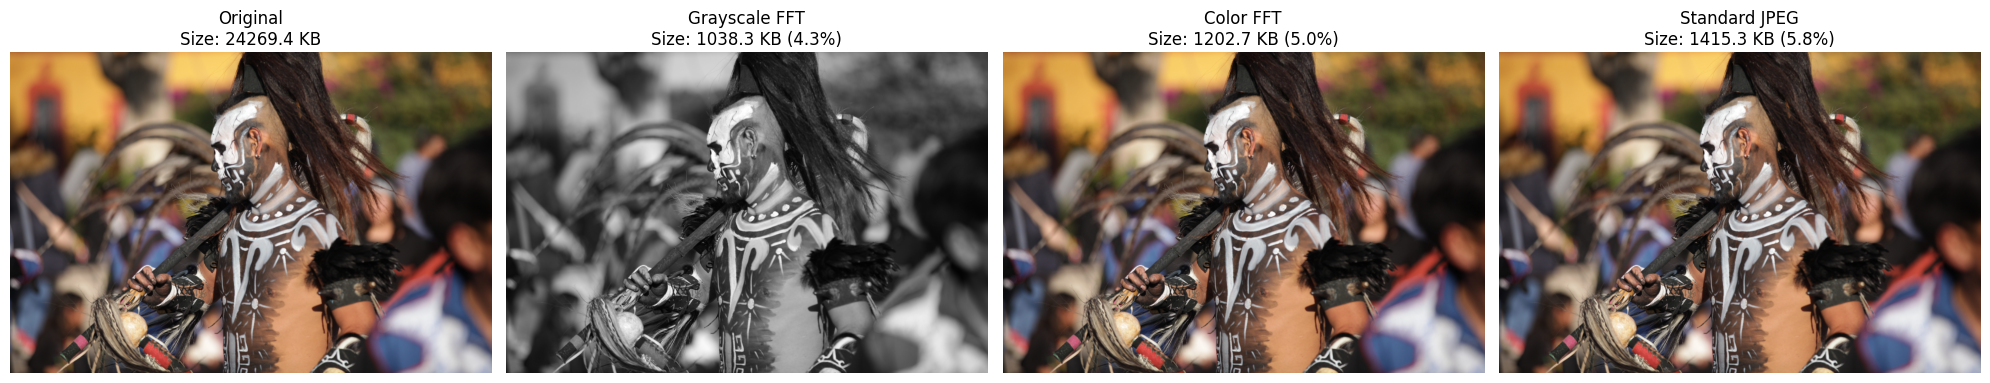

Original size: 24269.4 KB
Grayscale FFT compressed size: 1038.3 KB (4.3% of original)
Color FFT compressed size: 1202.7 KB (5.0% of original)
Grayscale FFT compression saved 23231.1 KB (95.7%)
Color FFT compression saved 23066.8 KB (95.0%)
Standard JPEG compressed size: 1415.3 KB (5.8% of original)
Standard JPEG compression saved 22854.1 KB (94.2%)

Numerical Comparison (FFT vs Standard JPEG):
Color FFT vs JPEG size difference: -212.7 KB
Color FFT is 85.0% the size of standard JPEG
Color FFT compression is 15.0% more efficient than standard JPEG
--------------------------------------------------
Sample 2: IMG_4632.cr2
Saved comparison image to images/comparison/IMG_4632_comparison.png


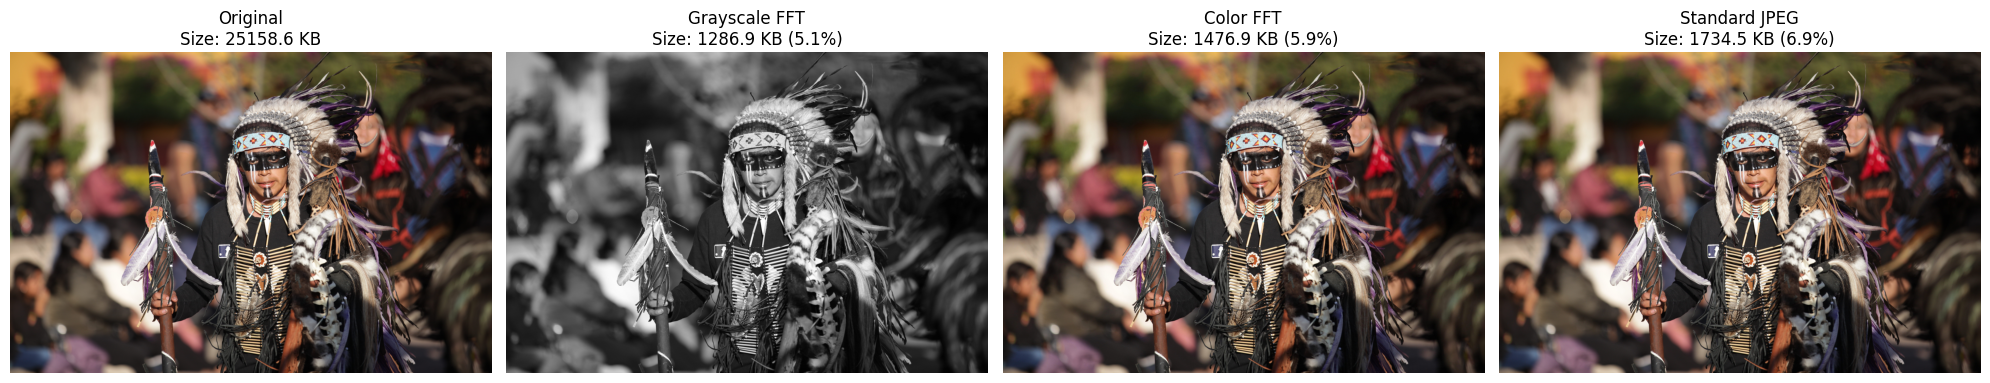

Original size: 25158.6 KB
Grayscale FFT compressed size: 1286.9 KB (5.1% of original)
Color FFT compressed size: 1476.9 KB (5.9% of original)
Grayscale FFT compression saved 23871.7 KB (94.9%)
Color FFT compression saved 23681.7 KB (94.1%)
Standard JPEG compressed size: 1734.5 KB (6.9% of original)
Standard JPEG compression saved 23424.0 KB (93.1%)

Numerical Comparison (FFT vs Standard JPEG):
Color FFT vs JPEG size difference: -257.6 KB
Color FFT is 85.1% the size of standard JPEG
Color FFT compression is 14.9% more efficient than standard JPEG
--------------------------------------------------
Sample 3: IMG_4638.cr2
Saved comparison image to images/comparison/IMG_4638_comparison.png


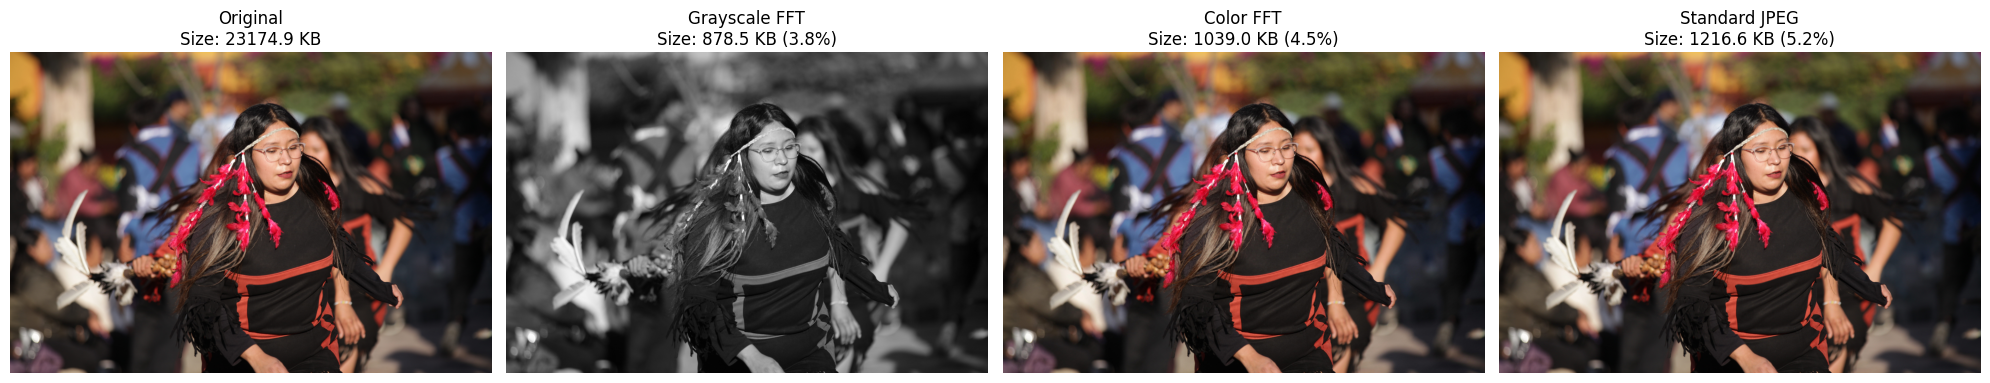

Original size: 23174.9 KB
Grayscale FFT compressed size: 878.5 KB (3.8% of original)
Color FFT compressed size: 1039.0 KB (4.5% of original)
Grayscale FFT compression saved 22296.4 KB (96.2%)
Color FFT compression saved 22135.9 KB (95.5%)
Standard JPEG compressed size: 1216.6 KB (5.2% of original)
Standard JPEG compression saved 21958.3 KB (94.8%)

Numerical Comparison (FFT vs Standard JPEG):
Color FFT vs JPEG size difference: -177.6 KB
Color FFT is 85.4% the size of standard JPEG
Color FFT compression is 14.6% more efficient than standard JPEG
--------------------------------------------------


In [10]:
for i, sample in enumerate(sample_files):
    original, grayscale, color, jpeg = sample
    print(f"Sample {i+1}: {original.name}")
    compare_images(str(original), str(grayscale), str(color), str(jpeg) if jpeg else None)


In [11]:
all_stats = []

for file in compressed_files:
    original_name = file.stem.replace("_compressed", "")

    original_file = None
    for ext in IMAGE_EXTS:
        potential_file = Path(RAW_DIR) / f"{original_name}{ext}"
        if potential_file.exists():
            original_file = potential_file
            break

    if original_file is None:
        continue

    color_file = Path(COMPRESSED_COLOR_DIR) / file.name
    if not color_file.exists():
        continue

    # Find corresponding JPEG compressed file
    jpeg_file = None
    jpeg_pattern = f"{original_name}_jpeg_q*.jpg"
    jpeg_matches = list(Path(JPEG_DIR).glob(jpeg_pattern))
    if jpeg_matches:
        jpeg_file = jpeg_matches[0]  # Use the first match if multiple exist

    original_size = get_file_size_kb(original_file)
    grayscale_size = get_file_size_kb(file)
    color_size = get_file_size_kb(color_file)

    grayscale_ratio = grayscale_size / original_size * 100
    color_ratio = color_size / original_size * 100

    stat_entry = {
        'name': original_file.name,
        'original_size': original_size,
        'grayscale_size': grayscale_size,
        'color_size': color_size,
        'grayscale_ratio': grayscale_ratio,
        'color_ratio': color_ratio
    }

    # Add JPEG stats if available
    if jpeg_file:
        jpeg_size = get_file_size_kb(jpeg_file)
        jpeg_ratio = jpeg_size / original_size * 100
        stat_entry.update({
            'jpeg_size': jpeg_size,
            'jpeg_ratio': jpeg_ratio,
            'fft_vs_jpeg_diff': color_size - jpeg_size,
            'fft_vs_jpeg_ratio': color_size / jpeg_size * 100,
            'jpeg_file': jpeg_file
        })

    all_stats.append(stat_entry)


Average Compression Statistics:
Average original size: 23161.1 KB
Average grayscale FFT compressed size: 1290.6 KB (5.9% of original)
Average color FFT compressed size: 1481.0 KB (6.7% of original)
Average grayscale FFT compression saved 21870.6 KB (94.1%)
Average color FFT compression saved 21680.1 KB (93.3%)

Average standard JPEG compressed size: 1746.6 KB (8.0% of original)
Average standard JPEG compression saved 21414.5 KB (92.0%)

Numerical Comparison (FFT vs Standard JPEG):
Average Color FFT vs JPEG size difference: -265.6 KB
Average Color FFT is 84.8% the size of standard JPEG
On average, Color FFT compression is 15.2% more efficient than standard JPEG


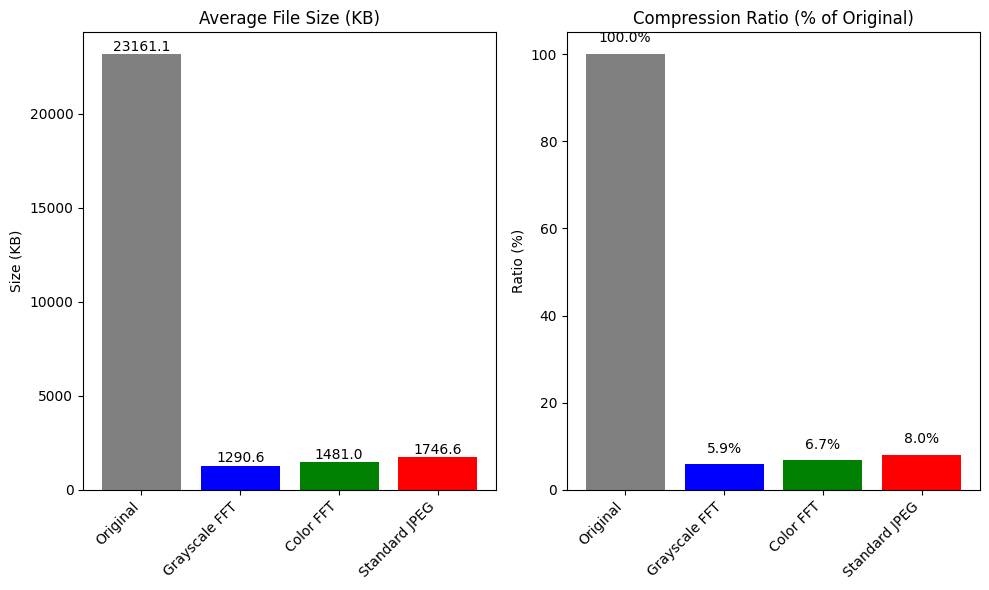

In [12]:
if all_stats:
    avg_original_size = np.mean([stat['original_size'] for stat in all_stats])
    avg_grayscale_size = np.mean([stat['grayscale_size'] for stat in all_stats])
    avg_color_size = np.mean([stat['color_size'] for stat in all_stats])
    avg_grayscale_ratio = np.mean([stat['grayscale_ratio'] for stat in all_stats])
    avg_color_ratio = np.mean([stat['color_ratio'] for stat in all_stats])

    # Calculate JPEG stats if available
    jpeg_stats = [stat for stat in all_stats if 'jpeg_size' in stat]
    has_jpeg_stats = len(jpeg_stats) > 0

    if has_jpeg_stats:
        avg_jpeg_size = np.mean([stat['jpeg_size'] for stat in jpeg_stats])
        avg_jpeg_ratio = np.mean([stat['jpeg_ratio'] for stat in jpeg_stats])
        avg_fft_vs_jpeg_diff = np.mean([stat['fft_vs_jpeg_diff'] for stat in jpeg_stats])
        avg_fft_vs_jpeg_ratio = np.mean([stat['fft_vs_jpeg_ratio'] for stat in jpeg_stats])

    print("Average Compression Statistics:")
    print(f"Average original size: {avg_original_size:.1f} KB")
    print(f"Average grayscale FFT compressed size: {avg_grayscale_size:.1f} KB ({avg_grayscale_ratio:.1f}% of original)")
    print(f"Average color FFT compressed size: {avg_color_size:.1f} KB ({avg_color_ratio:.1f}% of original)")
    print(f"Average grayscale FFT compression saved {avg_original_size - avg_grayscale_size:.1f} KB ({100 - avg_grayscale_ratio:.1f}%)")
    print(f"Average color FFT compression saved {avg_original_size - avg_color_size:.1f} KB ({100 - avg_color_ratio:.1f}%)")

    if has_jpeg_stats:
        print(f"\nAverage standard JPEG compressed size: {avg_jpeg_size:.1f} KB ({avg_jpeg_ratio:.1f}% of original)")
        print(f"Average standard JPEG compression saved {avg_original_size - avg_jpeg_size:.1f} KB ({100 - avg_jpeg_ratio:.1f}%)")

        print("\nNumerical Comparison (FFT vs Standard JPEG):")
        print(f"Average Color FFT vs JPEG size difference: {avg_fft_vs_jpeg_diff:.1f} KB")
        print(f"Average Color FFT is {avg_fft_vs_jpeg_ratio:.1f}% the size of standard JPEG")

        if avg_fft_vs_jpeg_diff < 0:
            print(f"On average, Color FFT compression is {-avg_fft_vs_jpeg_diff / avg_jpeg_size * 100:.1f}% more efficient than standard JPEG")
        else:
            print(f"On average, Standard JPEG compression is {avg_fft_vs_jpeg_diff / avg_color_size * 100:.1f}% more efficient than Color FFT")

        # Create a bar chart to visualize the compression comparison
        plt.figure(figsize=(10, 6))

        # Data for the chart
        methods = ['Original', 'Grayscale FFT', 'Color FFT', 'Standard JPEG']
        sizes = [avg_original_size, avg_grayscale_size, avg_color_size, avg_jpeg_size]
        ratios = [100, avg_grayscale_ratio, avg_color_ratio, avg_jpeg_ratio]

        # Create bar chart for file sizes
        plt.subplot(1, 2, 1)
        bars = plt.bar(methods, sizes, color=['gray', 'blue', 'green', 'red'])
        plt.title('Average File Size (KB)')
        plt.ylabel('Size (KB)')
        plt.xticks(rotation=45, ha='right')

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{height:.1f}',
                    ha='center', va='bottom', rotation=0)

        # Create bar chart for compression ratios
        plt.subplot(1, 2, 2)
        bars = plt.bar(methods, ratios, color=['gray', 'blue', 'green', 'red'])
        plt.title('Compression Ratio (% of Original)')
        plt.ylabel('Ratio (%)')
        plt.xticks(rotation=45, ha='right')

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{height:.1f}%',
                    ha='center', va='bottom', rotation=0)

        plt.tight_layout()
        plt.show()
else:
    print("No valid image pairs found for statistics calculation.")
